<a href="https://colab.research.google.com/github/juanpi19/medium-articles/blob/main/heterogeneous-treatment-effect/meta_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("ggplot")

import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
import xgboost

In [51]:
df = pd.read_csv("Sample - Superstore.csv", encoding='ISO-8859-1')

In [176]:
df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,month,weekday,year,discount,price,margin,unit_cost,t_learner_cate,q0_pred,rel_lift
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,11,1,2016,0,130.98,20.9568,110.0232,0.148943,3.344031,0.04454


# How does discount impact Quantity sold? Does the discount work better on some customers than others?

In [172]:
df['Order Date'] = pd.to_datetime(df['Order Date'])
df['month'] = df['Order Date'].dt.month
df['weekday'] = df['Order Date'].dt.weekday
df['year'] = df['Order Date'].dt.year

df.head(1)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,month,weekday,year,discount,price,margin,unit_cost,t_learner_cate,q0_pred,rel_lift
0,1,CA-2016-152156,2016-11-08,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,11,1,2016,0,130.98,20.9568,110.0232,0.148943,3.344031,0.04454


In [122]:
# binarize treatment
df['discount'] = np.where(df['Discount'] > 0, 1, 0)
df['price']  = df['Sales']  / df['Quantity']
df['margin'] = df['Profit'] / df['Quantity']
df['unit_cost'] = df['price'] - df['margin']

# One-hot encoding

In [137]:
y = 'Quantity'
w = 'discount'
X_cat = ['Segment', 'State', 'Category', 'Ship Mode']
X_cont = ['price', 'month', 'weekday']

temp_df = (
    df[['Row ID', w, y] + X_cont + X_cat]
      .pipe(pd.get_dummies, columns=X_cat, dtype=int, drop_first=True)
      .copy()
)

df_0 = temp_df[temp_df[w] == 0].copy()
df_1 = temp_df[temp_df[w] == 1].copy()

X_0 = df_0.drop(['Row ID', y, w], axis=1)
y_0 = df_0[y]
X_1 = df_1.drop(['Row ID', y, w], axis=1)
y_1 = df_1[y]

# First Stage Outcome Model

In [138]:
t_0 = xgboost.XGBRegressor(random_state=0).fit(X_0, y_0)  # outcome model when no discount
t_1 = xgboost.XGBRegressor(random_state=0).fit(X_1, y_1)  # outcome model when discount

### T - Learner estimator

In [139]:
X_all = X_0.columns

# Counterfactual prediction for each treatment and obtain CATE
t_learner_cate = t_1.predict(temp_df[X_all]) - t_0.predict(temp_df[X_all])

In [154]:
df['t_learner_cate'] = t_learner_cate
df['q0_pred']  = t_0.predict(temp_df[X_all])
df['rel_lift'] = temp_df['t_learner_cate']/temp_df['q0_pred']

In [169]:
df2 = df.groupby('Customer ID')[['q0_pred', 'rel_lift']].mean()

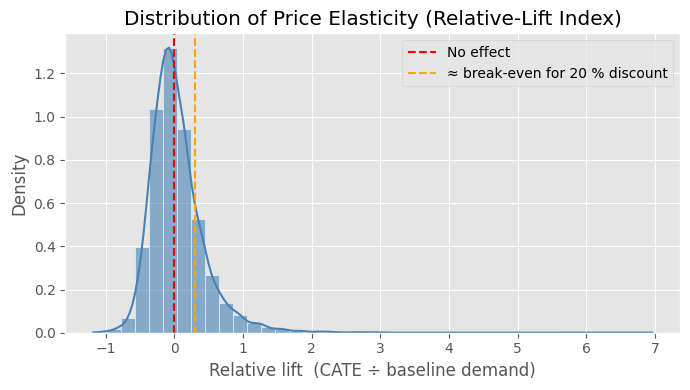

In [177]:
plt.figure(figsize=(7, 4))
lift = df["rel_lift"]

sns.histplot(lift,
             bins=40,
             kde=True,
             stat="density",
             color="steelblue",
             alpha=0.6)

plt.axvline(0, c="red", ls="--", label="No effect")
plt.axvline(0.30, c="orange", ls="--", label="≈ break-even for 20 % discount")  # tweak if needed

plt.title("Distribution of Price Elasticity (Relative-Lift Index)")
plt.xlabel("Relative lift  (CATE ÷ baseline demand)")          # add “(%)” if you scaled
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

# X - Learner

# Compute Treatment Effects

In [124]:
df_1['y0_hat'] = t_0.predict(X_1)
df_0['y1_hat'] = t_1.predict(X_0)

df_1['d1'] = df_1[y] - df_1['y0_hat']      # treated rows
df_0['d0'] = df_0['y1_hat'] - df_0[y]      # control rows

# Second Stage Model

In [125]:
g_1 = xgboost.XGBRegressor(random_state=0).fit(X_1, df_1['d1'])
g_0 = xgboost.XGBRegressor(random_state=0).fit(X_0, df_0['d0'])

# Propensity Score & CATE prediction

In [126]:
# propensity score for every row
prop_clf = LogisticRegression(penalty=None, solver='lbfgs', max_iter=1000)
prop_clf.fit(temp_df.drop(['Row ID', y], axis=1), temp_df[w])
pi = prop_clf.predict_proba(temp_df.drop(['Row ID', y], axis=1))[:, 1]

# CATE per row
X_all = temp_df.drop(['Row ID', y, w], axis=1)
tau_hat = (1 - pi) * g_1.predict(X_all) + pi * g_0.predict(X_all)

temp_df['tau_pred'] = tau_hat
temp_df['q0_pred']  = t_0.predict(X_all)

# Business Value

In [127]:
# final_df = (
#     temp_df.merge(df[['Row ID', 'Sales', 'Profit']], on='Row ID')
# )

# # price & cost estimation
# final_df['price']  = final_df['Sales']  / final_df['Quantity']
# final_df['margin'] = final_df['Profit'] / final_df['Quantity']
# final_df['unit_cost'] = final_df['price'] - final_df['margin']
# c = final_df['unit_cost'].median()

# # --- Business parameters ---------------------------------------
# P = final_df.loc[final_df['discount'] == 0, 'price'].median()   # list price
# d = 0.20                                                       # 20 % discount


# extra_unit_margin = P * (1 - d) - c

# # incremental profit per row
# final_df['delta_profit'] = (
#         final_df['tau_pred'] * extra_unit_margin
#       - final_df['q0_pred']  * P * d
# )

# # Decision: offer discount if Δprofit > 0
# final_df['offer_discount'] = (final_df['delta_profit'] > 0).astype(int)
# final_df[['Row ID', 'tau_pred', 'q0_pred', 'delta_profit', 'offer_discount']].head()

,Row ID,tau_pred,q0_pred,delta_profit,offer_discount
0,1,-0.329514,3.670901,-11.687892,0
1,2,-0.329514,3.670901,-11.687892,0
2,3,-0.338143,3.754805,-11.954878,0
3,4,-0.370569,3.964242,-12.619726,0
4,5,-0.124122,3.856807,-12.312141,0
